# Exploring Dataset from Yelp

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg, to_timestamp
from pyspark.sql.functions import split, explode, trim

business_filepath = "gs://info-323-qb-42/final_project/raw/yelp_academic_dataset_business.json"
review_filepath = "gs://info-323-qb-42/final_project/raw/yelp_academic_dataset_review.json"
user_filepath = "gs://info-323-qb-42/final_project/raw/yelp_academic_dataset_user.json"
restaurant_parquet = "gs://info-323-qb-42/final_project/cleaned/yelp_restaurant_cleaned.parquet"
user_parquet = "gs://info-323-qb-42/final_project/cleaned/yelp_user_cleaned.parquet"
review_parquet = "gs://info-323-qb-42/final_project/cleaned/yelp_review_cleaned.parquet"

In [2]:
# create Spark Session
spark = SparkSession.builder \
    .appName("Local Spark in Jupyter") \
    .getOrCreate()

25/06/11 11:32:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Business Table

The `attributes` column contains nested key-value pairs with values stored as strings (e.g., `"True"`, `"False"`). We will only focus on these attributes for our dataset:
- BusinessAcceptsCreditCards
- ByAppointmentOnly
- RestaurantsDelivery
- OutdoorSeating
- RestaurantsReservations
- RestaurantsTakeOut
- RestaurantsAttire
- BusinessAcceptsBitcoin
- BYOB
- DogsAllowed
- HappyHour

This step will:
- Parse the nested structure
- Convert string boolean values to actual `BooleanType`
- Flatten the dictionary into separate columns for easier analysis

**Total: 23 attributes**

### Transform data and unnest attributes from raw dataset

In [3]:
business_df = spark.read.json(business_filepath)

# List of string columns with "True"/"False" values
string_flag_columns = [
    "attributes.BusinessAcceptsCreditCards",
    "attributes.ByAppointmentOnly",
    "attributes.RestaurantsDelivery",
    "attributes.OutdoorSeating",
    "attributes.RestaurantsReservations",
    "attributes.RestaurantsTakeOut",
    "attributes.RestaurantsAttire",
    "attributes.BusinessAcceptsBitcoin",
    "attributes.BYOB",
    "attributes.DogsAllowed",
    "attributes.HappyHour"
]

# Convert each to BooleanType
for column_name in string_flag_columns:
    business_df = business_df.withColumn(
        column_name,
        when(col(column_name) == "True", True)
        .when(col(column_name) == "False", False)
        .otherwise(None)
    )

for col_name in string_flag_columns:
    flat_name = col_name.split(".")[-1]  # e.g., "attributes.DogsAllowed" → "DogsAllowed"
    business_df = business_df.withColumnRenamed(col_name, flat_name)

business_df = business_df.filter(col("_corrupt_record").isNull())
business_df = business_df.drop('attributes', 'hours', 'stars', 'review_count', '_corrupt_record')

25/06/11 11:33:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
restaurant_df = business_df.filter(
    col("categories").isNotNull() & col("categories").contains("Restaurants")
)

### Store cleaned restaurants data into parquet for less storage cost
For the simplicity of this project, I will only use 2 zones for data: raw and cleaned

In [16]:
restaurant_df.write.parquet("gs://info-323-qb-42/final_project/cleaned/yelp_restaurant_cleaned.parquet")

## User Table

- user_id
- name
- yelping_since
- fans
- elite
- funny
- cool
- useful
- compliment_hot
- compliment_more
- compliment_profile
- compliment_cute
- compliment_list
- compliment_note
- compliment_plain
- compliment_cool
- compliment_funny
- compliment_writer
- compliment_photos

**Total: 19 attributes**

In [17]:
user_df = spark.read.json(user_filepath)

In [19]:
# Add columns for total_compliment and total_vote by other users
user_df = user_df.withColumn("total_vote", user_df.useful + user_df.funny + user_df.cool)
user_df = user_df.withColumn("total_compliment", user_df.compliment_cool + user_df.compliment_cute \
                             + user_df.compliment_funny + user_df.compliment_hot + user_df.compliment_list + user_df.compliment_more \
                             + user_df.compliment_note + user_df.compliment_photos + user_df.compliment_plain + user_df.compliment_profile \
                             + user_df.compliment_writer)
cleaned_user_df = user_df.drop("friends", 'review_count', 'average_starts')
cleaned_user_df.write.mode("overwrite").parquet("gs://info-323-qb-42/final_project/cleaned/yelp_user_cleaned.parquet")

## Review Table

- business_id
- review_id
- stars
- user_id
- review_timestamp

**Total: 6 attributes**

In [20]:
review_df = spark.read.json(review_filepath)
review_df = review_df.withColumn("review_timestamp", to_timestamp("date", "yyyy-MM-dd HH:mm:ss"))
cleaned_review_df = review_df.drop("cool", "funny", "useful", "date")
cleaned_review_df.write.mode("overwrite").parquet("gs://info-323-qb-42/final_project/cleaned/yelp_review_cleaned.parquet")

## Analysis

In [5]:
# Load parquet file
user_df = spark.read.parquet(user_parquet)
restaurant_df = spark.read.parquet(restaurant_parquet)
review_df = spark.read.parquet(review_parquet)

In [26]:
# Show schema
user_df = spark.read.parquet(user_parquet).printSchema()
restaurant_df = spark.read.parquet(restaurant_parquet).printSchema()
review_df = spark.read.parquet(review_parquet).printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- total_vote: long (nullable = true)
 |-- total_compliment: long (nullable = true)

root
 |-- address: string (nullable = true)
 |-- business_id: st

In [6]:
joined_df = review_df.join(restaurant_df, on="business_id", how="inner")

In [8]:
state_success = joined_df.groupBy("state").agg(
    avg("stars").alias("avg_rating"),
    count("review_id").alias("num_reviews")
).filter(col("num_reviews") > 2000) \
 .orderBy(col("avg_rating").desc())

state_success.show(truncate=False)

+-----+------------------+-----------+
|state|avg_rating        |num_reviews|
+-----+------------------+-----------+
|LA   |3.905077843231546 |133088     |
|CA   |3.884833831345088 |43841      |
|FL   |3.841561093374547 |177286     |
|IN   |3.8210063733552633|77824      |
|MO   |3.8151270758683427|90143      |
|TN   |3.8087977382720783|104345     |
|ID   |3.8030344954805386|21684      |
|PA   |3.76746416840848  |267920     |
|NV   |3.762362515325432 |56279      |
|AZ   |3.7408887254246355|59816      |
|DE   |3.646779729456895 |9906       |
|AB   |3.6448957189901208|16398      |
|NJ   |3.623893107410829 |44381      |
|IL   |3.6235867878519175|9022       |
+-----+------------------+-----------+



In [9]:
city_success = joined_df.groupBy("city").agg(
    avg("stars").alias("avg_rating"),
    count("review_id").alias("num_reviews")
).filter(col("num_reviews") > 2000) \
 .orderBy(col("avg_rating").desc())

city_success.show(truncate=False)

+----------------+------------------+-----------+
|city            |avg_rating        |num_reviews|
+----------------+------------------+-----------+
|Tarpon Springs  |4.241073689541656 |3949       |
|Saint Petersburg|4.081200419098938 |13362      |
|St. Pete Beach  |4.068922305764411 |3192       |
|University City |4.043198181129216 |2639       |
|St Pete Beach   |4.035266457680251 |2552       |
|Madeira Beach   |3.995124329595319 |2051       |
|Dunedin         |3.989559877175026 |4885       |
|Clayton         |3.971918134221799 |4202       |
|Carpinteria     |3.965330117576123 |3317       |
|Collingswood    |3.9537414965986395|2205       |
|St. Petersburg  |3.9413915229064322|8753       |
|Newtown         |3.9372837370242215|2312       |
|New Orleans     |3.9333190509346045|112026     |
|Santa Barbara   |3.917869317276753 |31389      |
|Boise           |3.8893529525155817|15563      |
|Wesley Chapel   |3.8862188766647368|3454       |
|Indianapolis    |3.8770054379031986|59214      |


In [40]:
# Aggregate: average rating and review count per business
restaurant_stats_df = joined_df.groupBy("business_id").agg(
    avg("stars").alias("avg_rating"),
    count("review_id").alias("num_reviews")
)

# Filter only restaurants with more than 2000 reviews
top_restaurants_df = restaurant_stats_df.filter(col("num_reviews") > 2000)

# Show the result
top_restaurants_df.show(truncate=False)

+----------------------+------------------+-----------+
|business_id           |avg_rating        |num_reviews|
+----------------------+------------------+-----------+
|UFCN0bYdHroPKu6KV5CJqg|4.471453287197232 |2312       |
|mhrW9O0O5hXGXGnEYBVoag|4.36218864842793  |2449       |
|UCMSWPqzXjd7QHq7v8PJjQ|4.3914798206278025|2230       |
|vN6v8m4DO45Z4pp8yxxF_w|4.460849056603774 |2120       |
|C9K3579SJgLPp0oAOM29wg|4.344792024750774 |2909       |
|_C7QiQQc47AOEv4PE3Kong|4.29201046488227  |4969       |
|8uF-bhJFgT4Tn6DTb27viA|4.378199052132701 |2110       |
|W4ZEKkva9HpAdZG88juwyQ|4.19281663516068  |2116       |
|pSmOH4a3HNNpYM82J5ycLA|3.997608799617408 |2091       |
|Zi-F-YvyVOK0k5QD7lrLOg|4.225099601593626 |2008       |
|GBTPC53ZrG1ZBY3DT8Mbcw|4.177429736108131 |4661       |
|SZU9c8V2GuREDN5KgyHFJw|3.911620294599018 |2444       |
|VQcCL9PiNL_wkGf-uF3fjg|3.7866303925378935|5146       |
|ctHjyadbDQAtUFfkcAFEHw|4.5486920895052005|3173       |
|hfbZ97Te3T4jeWN6GgsGrQ|4.246829268292683 |2050 

In [10]:
from pyspark.sql.functions import concat_ws

# Create a new column that combines city and state
joined_df = joined_df.withColumn("city_state", concat_ws(", ", col("city"), col("state")))

# Group by the new combined column and compute metrics
city_state_success = joined_df.groupBy("city_state").agg(
    avg("stars").alias("avg_rating"),
    count("review_id").alias("num_reviews")
).filter(col("num_reviews") > 2000) \
 .orderBy(col("avg_rating").desc())

# Show results
city_state_success.show(truncate=False)

+--------------------+------------------+-----------+
|city_state          |avg_rating        |num_reviews|
+--------------------+------------------+-----------+
|Tarpon Springs, FL  |4.241073689541656 |3949       |
|Saint Petersburg, FL|4.081200419098938 |13362      |
|St. Pete Beach, FL  |4.068922305764411 |3192       |
|University City, MO |4.043198181129216 |2639       |
|St Pete Beach, FL   |4.035266457680251 |2552       |
|Madeira Beach, FL   |3.995124329595319 |2051       |
|Dunedin, FL         |3.989559877175026 |4885       |
|Clayton, MO         |3.9785954785954787|4158       |
|Carpinteria, CA     |3.965330117576123 |3317       |
|Collingswood, NJ    |3.9537414965986395|2205       |
|St. Petersburg, FL  |3.9413915229064322|8753       |
|Newtown, PA         |3.9372837370242215|2312       |
|New Orleans, LA     |3.9333190509346045|112026     |
|Santa Barbara, CA   |3.917869317276753 |31389      |
|Boise, ID           |3.8893529525155817|15563      |
|Wesley Chapel, FL   |3.8862

In [12]:
from pyspark.sql.functions import month, year, count

# Add year and month columns
review_df = review_df.withColumn("review_year", year("review_timestamp")) \
                     .withColumn("review_month", month("review_timestamp"))

# Count reviews per month/year
monthly_review_counts = review_df.groupBy("review_year", "review_month") \
    .agg(count("*").alias("num_reviews")) \
    .orderBy("review_year", "review_month")

# Aggregate across all years by month only
monthly_trend = review_df.groupBy("review_month") \
    .agg(count("*").alias("num_reviews")) \
    .orderBy("review_month")

monthly_trend.show()

+------------+-----------+
|review_month|num_reviews|
+------------+-----------+
|           1|     604532|
|           2|     544125|
|           3|     598555|
|           4|     551471|
|           5|     586575|
|           6|     601737|
|           7|     654627|
|           8|     636384|
|           9|     565374|
|          10|     571809|
|          11|     531518|
|          12|     543573|
+------------+-----------+



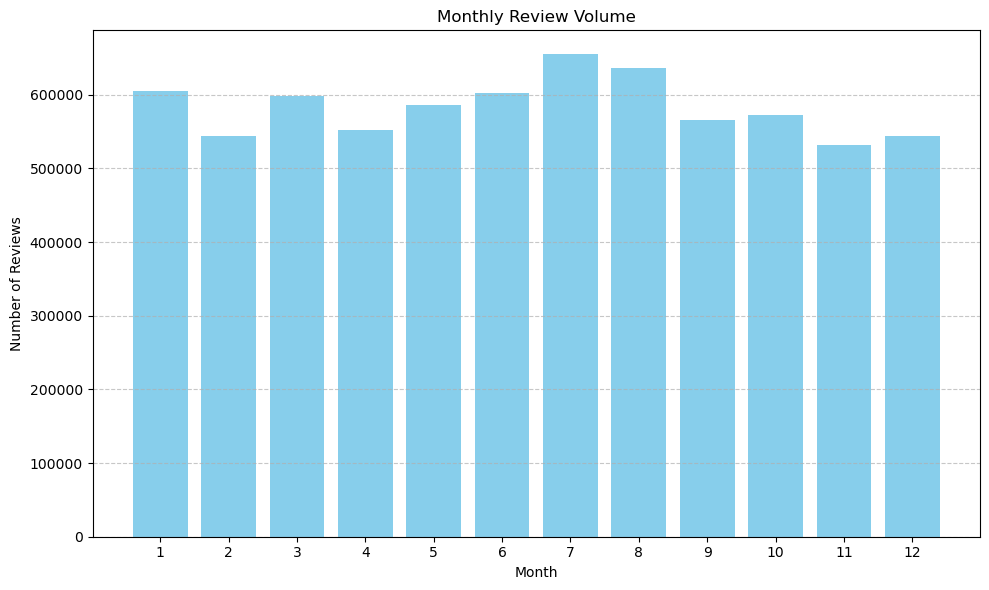

In [13]:
# Convert to Pandas for plotting
monthly_trend_pd = monthly_trend.toPandas()

# Plot using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(monthly_trend_pd["review_month"], monthly_trend_pd["num_reviews"], color="skyblue")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Review Volume")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Join review and restaurant data
joined_df = review_df.join(restaurant_df, on="business_id", how="inner")

# Aggregate review data per business
from pyspark.sql.functions import avg, count

agg_df = joined_df.groupBy("business_id").agg(
    avg("stars").alias("avg_rating"),
    count("review_id").alias("review_count")
)

# Join back to restaurant features
features_df = agg_df.join(restaurant_df, on="business_id", how="inner")

In [31]:
selected_cols = [
    "BusinessAcceptsCreditCards",
    "RestaurantsDelivery",
    "OutdoorSeating",
    "RestaurantsReservations",   
    "RestaurantsTakeOut"          
]

# Join with non-null avg_rating and review_count
final_cols = ["avg_rating", "review_count"] + selected_cols

# Filter out rows missing avg_rating or review_count, then fill booleans
data = features_df.select(*final_cols) \
    .filter("avg_rating IS NOT NULL AND review_count IS NOT NULL") \
    .fillna(False)

In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

feature_cols = [c for c in data.columns if c != "avg_rating"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_data = assembler.transform(data).select("features", "avg_rating")

# Split and train
train, test = final_data.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestRegressor(labelCol="avg_rating", featuresCol="features")
model = rf.fit(train)

# Predict and evaluate
predictions = model.transform(test)
rmse = RegressionEvaluator(labelCol="avg_rating", predictionCol="prediction", metricName="rmse").evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.7710347617376422
